In [1]:
#default_exp eda

# Exploratory Data Analysis

<br>

### Imports

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wpdhack import data, feature

In [3]:
data_dir = '../data'

data_kwargs = {
    'real_power_sub_dir': 'real_power',
    'weather_sub_dir': 'weather',
    'real_power_time_period': '_pre_august',
    'real_power_site': 'Staplegrove_CB905',
    'weather_grid_point': 'staplegrove_1',
    'weather_interpolate_method': 'interpolate'
}

cols_subset = ['value', 'temperature', 'solar_irradiance', 'pressure', 'spec_humidity', 'hour', 
               'windspeed_north', 'windspeed_east', 'doy', 'speed', 'direction', 'weekend', 'hcdh']

features_kwargs = {'features': ['temporal', 'dir_speed', 'hcdh']}

df_features, df_target = data.construct_baseline_features_target_dfs(data_dir, **data_kwargs)
df_features = feature.create_additional_features(df_features, **features_kwargs)
df_features = feature.process_features(df_features, cols_subset=cols_subset)

df_features.head()

,value,temperature,solar_irradiance,windspeed_north,windspeed_east,pressure,spec_humidity,hour,doy,weekend,direction,speed,hcdh
time,,,,,,,,,,,,,
2019-11-01 00:00:00+00:00,1.101302,12.487909,0.0,4.610671,-1.894359,99478.780,0.008825,0.0,305,False,157.664002,4.984665,0.0
2019-11-01 00:30:00+00:00,1.084653,12.490152,0.0,4.701822,-2.196463,99377.225,0.008861,0.5,305,False,154.960298,5.189565,0.0
2019-11-01 01:00:00+00:00,0.998729,12.492395,0.0,4.792974,-2.498568,99275.670,0.008896,1.0,305,False,152.467054,5.405131,0.0
2019-11-01 01:30:00+00:00,0.914548,12.565637,0.0,4.765775,-2.378908,99180.225,0.008974,1.5,305,False,153.473232,5.326520,0.0
2019-11-01 02:00:00+00:00,0.875550,12.638879,0.0,4.738576,-2.259248,99084.780,0.009051,2.0,305,False,154.509224,5.249601,0.0


<AxesSubplot:xlabel='time'>

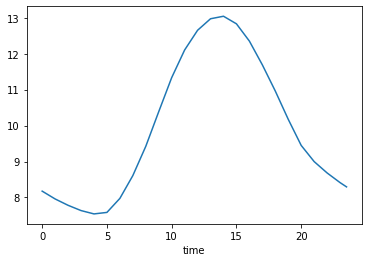

In [4]:
s_tod = pd.Series(df_features.index.hour+df_features.index.minute/60, index=df_features.index)
s_avg_daily_temp = df_features['temperature'].groupby(s_tod).mean()

s_avg_daily_temp.plot()

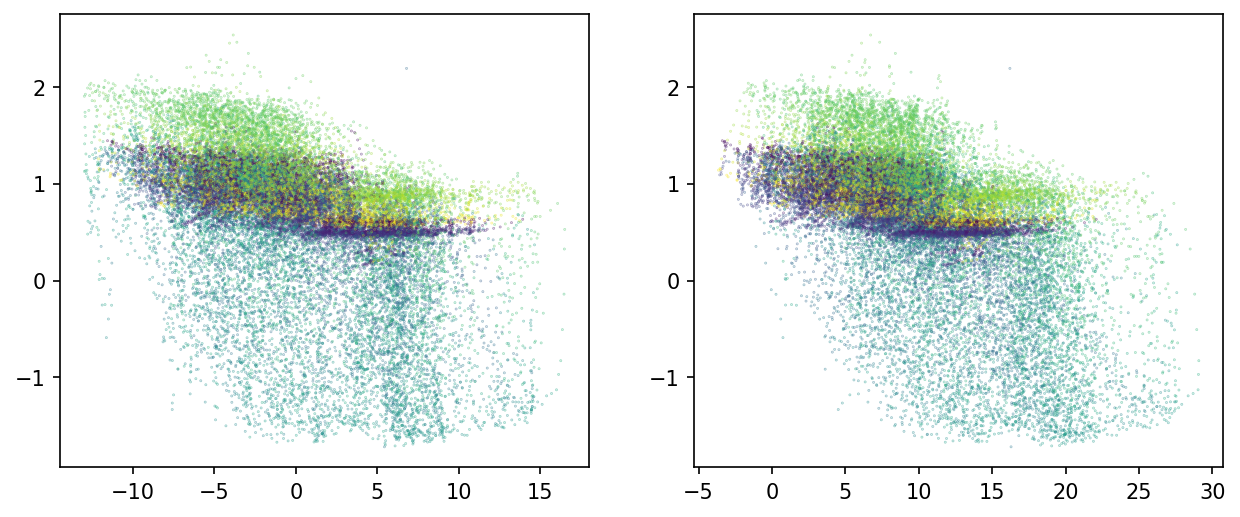

In [5]:
s_temp_dev = df_features['temperature'] - s_tod.map(s_avg_daily_temp)

# should do a facet plot for different seasons

# Plotting
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(10, 4))

axs[0].scatter(s_temp_dev, df_features['value'], c=s_tod, s=0.1, alpha=0.5)
axs[1].scatter(df_features['temperature'], df_features['value'], c=s_tod, s=0.1, alpha=0.5)

<AxesSubplot:xlabel='time'>

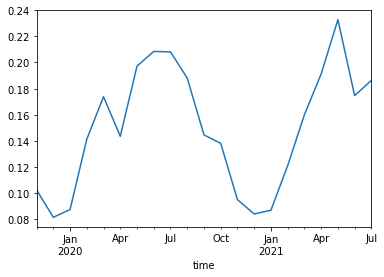

In [6]:
s_avg_to_max = df_target['value_max'] - df_features['value']
s_avg_to_min = df_target['value_min'] - df_features['value']

s_avg_to_max.resample('MS').mean().plot() # should do the mean and max/min, will need to lag

In [7]:
df_spread = (
    (df_target['value_max'] - df_features['value'])
    .to_frame()
    .rename(columns={0: 'max'})
    .assign(min=df_target['value_min'] - df_features['value'])
    .unstack()
    .reset_index()
    .rename(columns={'level_0': 'spread_type', 0: 'spread'})
    .pipe(lambda df: df.assign(month=pd.to_datetime(df['time']).dt.strftime('%Y-%m')))
)

df_spread.head()

,spread_type,time,spread,month
0,max,2019-11-01 00:00:00+00:00,0.044048,2019-11
1,max,2019-11-01 00:30:00+00:00,0.054785,2019-11
2,max,2019-11-01 01:00:00+00:00,0.048443,2019-11
3,max,2019-11-01 01:30:00+00:00,0.044183,2019-11
4,max,2019-11-01 02:00:00+00:00,0.029633,2019-11


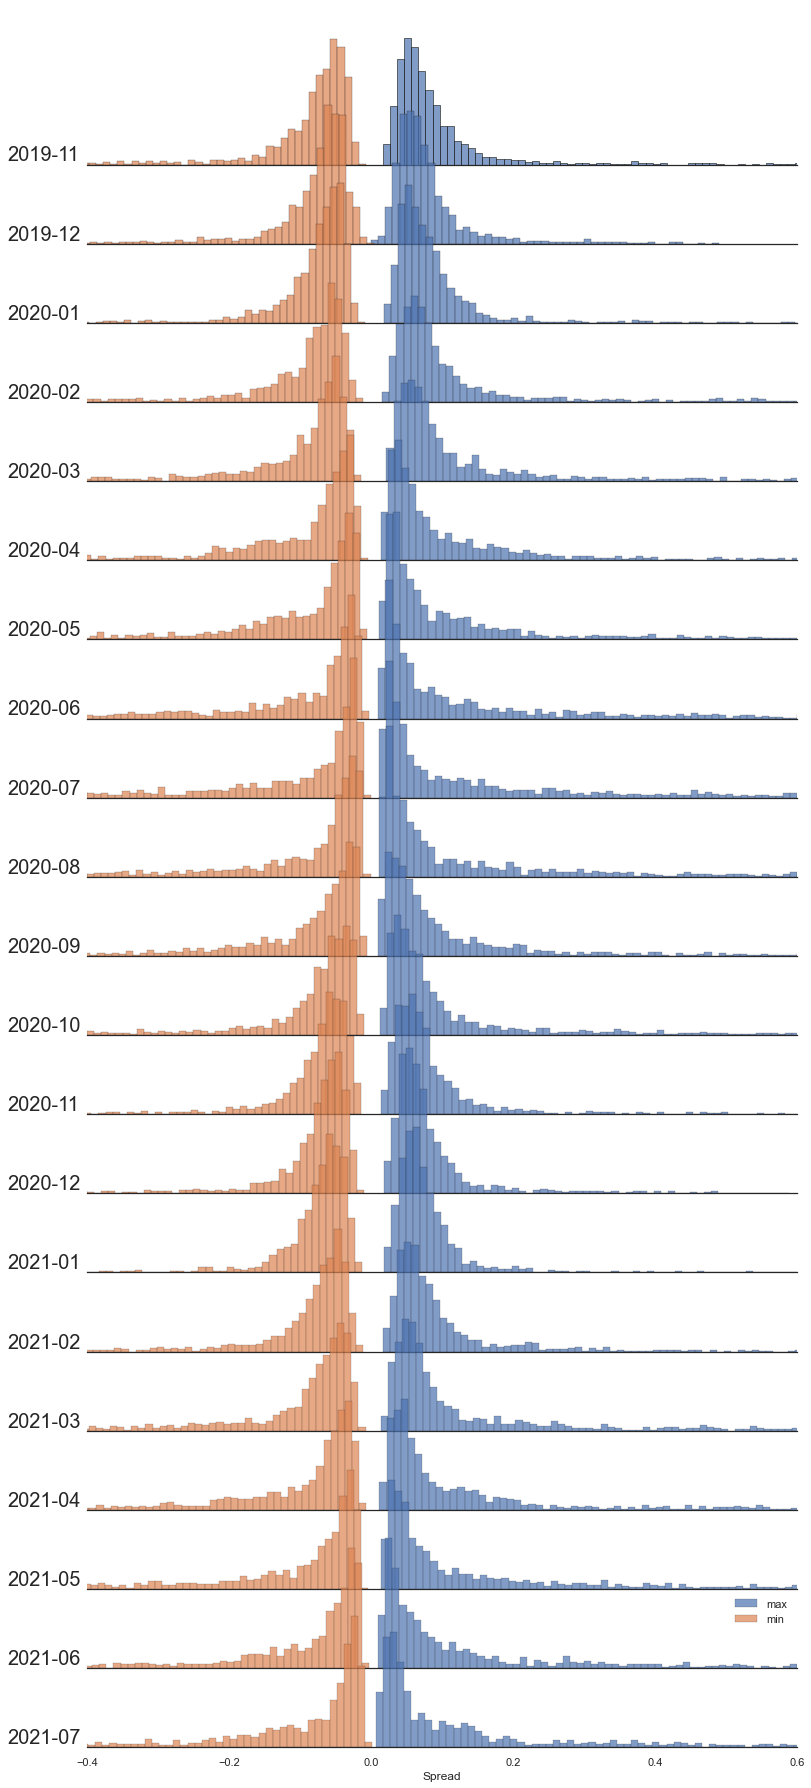

In [16]:
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)}) # probably better to use a theme context

g = sns.FacetGrid(df_spread, row='month', hue='spread_type', aspect=9, height=1.2)

g.map_dataframe(sns.histplot, x='spread', fill=True, alpha=0.7, binwidth=0.01, edgecolor='k')

g.fig.subplots_adjust(hspace=-.5)
plt.gca().set_xlim(-0.4, 0.6)
g.set_titles('', row_template='{row_name}')
g.set(yticks=[])
g.despine(left=True)

ax = plt.gca()
ax.set_xlim(-0.4, 0.6)
ax.set_xlabel('Spread')
ax.legend(frameon=False)

[
    ax.set_ylabel(month, loc='bottom', rotation=0, fontsize=20, labelpad=80) 
    for month, ax in 
    zip(sorted(df_spread['month'].unique()), g.fig.get_axes())
];

In [9]:
# ^ Start by fitting a weibull dist to some of these

In [10]:
# split up the time-series into seasonality, trend and external
# demand with time (both line plot and heatmap)
# demand with temp
# demand with wind speed
# demand with solar (time-adjusted)
# how did covid impact it?
# look for outliers